In [2]:
import numpy as np 
import pandas as pd 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score
import matplotlib.pyplot as plt 
%matplotlib inline
dropout = pd.read_excel(r"C:/Users/ADMIN/Documents/Codebase/Data-science-projects/Education/data/dropout.xls")
pd.set_option('display.max_columns', 500)

In [3]:
print("\n Correlation between dropout rates at different stages of schooling\n")
dropout[['PRIMARY_TOTAL', 'UPPER_PRIMARY_TOTAL', 'SECONDARY_TOTAL','HRSECONDARY_TOTAL']].corr().style.background_gradient(cmap='RdBu')


 Correlation between dropout rates at different stages of schooling



,PRIMARY_TOTAL,UPPER_PRIMARY_TOTAL,SECONDARY_TOTAL,HRSECONDARY_TOTAL
PRIMARY_TOTAL,1.000000,0.786048,0.228586,-0.165536
UPPER_PRIMARY_TOTAL,0.786048,1.000000,0.471399,-0.084944
SECONDARY_TOTAL,0.228586,0.471399,1.000000,-0.063669
HRSECONDARY_TOTAL,-0.165536,-0.084944,-0.063669,1.000000


In [4]:
states=[]
for i in range(36):
    states.append(dropout.STATE_UT.iloc[3*i])
states=pd.DataFrame(states, columns=['State'])
dropout.drop(['STATE_UT','YEAR'],axis=1,inplace=True)
x=pd.DataFrame()
for i in range(36):
    x[i]=dropout.iloc[3*i+0:i*3+3,:].mean()
x=x.transpose()    

In [5]:
def create_clusters(x):

    scores=[]
    for i in range(4,36):
        k=KMeans(n_clusters=i,n_init=500, max_iter=500)
        k.fit(x[['PRIMARY_TOTAL', 'UPPER_PRIMARY_TOTAL', 'SECONDARY_TOTAL','HRSECONDARY_TOTAL']])
        label=KMeans.predict(k,x[['PRIMARY_TOTAL', 'UPPER_PRIMARY_TOTAL', 'SECONDARY_TOTAL','HRSECONDARY_TOTAL']])
        scores.append(silhouette_score(x, label))

    pd.DataFrame(scores).plot()
    best_cluster_no=np.argmax(scores[2:36])+2
    plt.axvline(best_cluster_no)
    plt.text(best_cluster_no, 0.34,s=f"Max silhoutte score at n={best_cluster_no}")
    plt.xlabel("No. of clusters")
    plt.ylabel("Silhoutte score")
    kk=KMeans(n_clusters=best_cluster_no)

    kk.fit(x[['PRIMARY_TOTAL', 'UPPER_PRIMARY_TOTAL', 'SECONDARY_TOTAL','HRSECONDARY_TOTAL']])
    lab = pd.DataFrame(kk.labels_,columns=['Labels'])
    result=pd.concat([states['State'],x,lab['Labels']],axis=1)
    return result

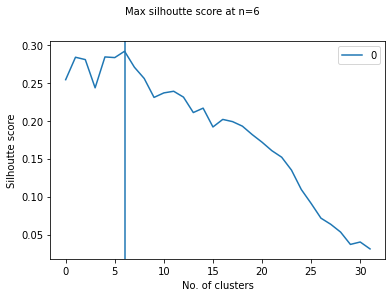

In [6]:
result=create_clusters(x)

In [13]:
reqd=result.groupby('Labels')[result.columns[1:-1]].agg('mean')
reqd['Average dropout'] = (reqd['HRSECONDARY_TOTAL']+reqd['SECONDARY_TOTAL']+reqd['UPPER_PRIMARY_TOTAL']+reqd['PRIMARY_TOTAL'])/4
reqd.sort_values(['Average dropout'], ascending=False).style.background_gradient(cmap='Greens')

,PRIMARY_BOYS,PRIMARY_GIRLS,PRIMARY_TOTAL,UPPER_PRIMARY_BOYS,UPPER_PRIMARY_GIRLS,UPPER_PRIMARY_TOTAL,SECONDARY_BOYS,SECONDARY_GIRLS,SECONDARY_TOTAL,HRSECONDARY_BOYS,HRSECONDARY_GIRLS,HRSECONDARY_TOTAL,Average dropout
Labels,,,,,,,,,,,,,
0,10.330000,9.690556,10.010000,8.924444,9.190556,9.053889,23.383333,24.190556,23.773889,4.001667,3.218889,3.513889,11.587917
4,6.784444,5.926667,6.375556,4.437778,5.215556,4.633333,17.956667,17.154444,17.572222,16.133333,11.418889,13.683333,10.566111
5,2.216667,1.985556,2.084444,3.525556,3.204444,3.210000,33.901111,33.630000,33.771111,2.826667,1.251111,1.921111,10.246667
2,2.738333,2.649444,2.677778,3.747778,4.386111,3.964444,19.886111,19.093889,19.563889,6.207222,4.964444,5.587222,7.948333
3,1.054444,0.640556,0.851111,1.462778,1.269444,1.148889,8.697778,6.648333,7.716111,15.424444,9.226667,12.514444,5.557639
1,3.560278,3.564167,3.560833,2.321389,2.959444,2.469167,12.516111,11.215000,11.882500,3.686389,3.297500,3.454167,5.341667


In [8]:
grouping=result[['State','Labels']]
clusters=pd.DataFrame()
for l in grouping.Labels.unique():
    clusters=pd.concat([clusters,pd.Series(np.array(grouping.State[grouping.Labels==l]), name=f"Cluster {l+1}").to_frame()],axis=1)
clusters.replace({np.nan:'-'},inplace=True)
clusters.sort_index(axis=1)    

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6
0,Assam,Andhra Pradesh,Chhattisgarh,A & N Islands,Arunachal Pradesh,Bihar
1,Jharkhand,Haryana,Dadra & Nagar Haveli,Chandigarh,Daman & Diu,Karnataka
2,Madhya Pradesh,Kerala,Gujarat,Delhi,Jammu & Kashmir,Odisha
3,Meghalaya,Lakshadweep,Telangana,Goa,-,-
4,Mizoram,Maharashtra,Tripura,Himachal Pradesh,-,-
5,Nagaland,Manipur,West Bengal,Sikkim,-,-
6,-,Puducherry,-,-,-,-
7,-,Punjab,-,-,-,-
8,-,Rajasthan,-,-,-,-
9,-,Tamil Nadu,-,-,-,-
